### >>>INGESTA DE DATOS

In [1]:
import psycopg2
from psycopg2 import sql
import pandas as pd
import time

#Delay de 15 segundos
time.sleep(20)

# Credenciales de la base de datos
dbname = "DBInmerso"
user = "postgres"
password = "postgres"
host = "postgres"  # Cambia esto según tu configuración
port = "5432"

# Crear la cadena de conexión
connection_string = f"dbname={dbname} user={user} password={password} host={host} port={port}"

# Intentar establecer la conexión
try:
    with psycopg2.connect(connection_string) as connection:
        # Consulta para concatenar las tablas
        query_concatenar_1 = """
                            SELECT
                                u.dni,
                                u.nombre,
                                u.apellido,
                                u.edad,
                                u.fecha_de_nacimiento,
                                u.id_solicitud,
                                u.usuario_solicitante,
                                u.oficio_especial,
                                r.ingresos,
                                d.grado_dis,
                                fn.tipo_fam_num,
                                p.valoracion_patrimonio,
                                p.coche,
                                p.arrendador,
                                h.resultado_solicitud_t_1,
                                h.resultado_solicitud_t_2,
                                h.viajes_t_1,
                                h.viajes_t_2,
                                h.scoring_ind_participacion_previa,
                                h.suma_viajes_t_1_y_t_2
                            FROM
                                usuarios AS u
                            JOIN renta AS r ON u.dni = r.dni
                            JOIN discapacidad AS d ON u.dni = d.dni
                            JOIN familia_numerosa AS fn ON u.dni = fn.dni
                            JOIN patrimonio AS p ON u.dni = p.dni
                            JOIN historial_usuarios AS h ON u.dni = h.dni;
                            """
        query_concatenar_2 = """
                            SELECT 
                                u.dni, 
                                u.id_solicitud, 
                                s.*
                            FROM usuarios u
                            LEFT JOIN solicitudes s ON u.id_solicitud = s.id_solicitud;
                                """
                                


        # Crear un DataFrame con los resultados de la consulta concatenada
        df = pd.read_sql_query(query_concatenar_1, connection)
        df_2 = pd.read_sql_query(query_concatenar_2, connection)

except psycopg2.Error as e:
    print(f"Error al conectar a la base de datos: {e}")

#>>>>>Ponderaciones<<<<<<#

edad_weight = 0.2
discapacidad_weight = 0.05
renta_wheigt = 0.2
patrimonio_weight = 0.15
familia_weight = 0.05
arrendador_wight = 0.10
participacion_previa_weight = 0.15
coche_wight = 0.05
oficio_especial_wight = 0.05

#modificar las ponderaciones, no debe ponderar todo igual

C:\Users\DELL\AppData\Local\Temp\ipykernel_18076\3400908608.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_concatenar_1, connection)
C:\Users\DELL\AppData\Local\Temp\ipykernel_18076\3400908608.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_2 = pd.read_sql_query(query_concatenar_2, connection)


In [2]:
# Autorechazos 

df

,dni,nombre,apellido,edad,fecha_de_nacimiento,id_solicitud,usuario_solicitante,oficio_especial,ingresos,grado_dis,tipo_fam_num,valoracion_patrimonio,coche,arrendador,resultado_solicitud_t_1,resultado_solicitud_t_2,viajes_t_1,viajes_t_2,scoring_ind_participacion_previa,suma_viajes_t_1_y_t_2
0,95822412,Juan Manuel,Santos,62,1910-10-31,52,True,True,1533.0,0,1,2000000.0,False,False,0,0,0,2,70.0,2
1,46913810,Lorenzo,Valbuena,70,1933-12-01,458,False,True,2309.0,2,0,48608.0,True,True,1,3,1,1,88.0,2
2,28728463,Marco,Lobato,61,1937-07-13,1386,False,True,1766.0,1,1,140513.0,True,False,0,1,1,1,81.0,2
3,83197857,Leticia,Pereira,60,1916-03-01,1210,True,False,598.0,1,0,116018.0,True,True,2,2,1,0,56.0,1
4,66629388,Patricia,Galiano,57,1961-09-08,62,True,True,1601.0,1,2,38802.0,False,False,0,1,2,1,73.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,69148126,Mariana,Andres,57,1940-01-28,57629,True,True,2372.0,0,1,350217.0,False,True,1,1,0,1,58.0,1
1496,45113084,Rosa,Robles,75,1916-02-25,51689,True,True,402.0,2,0,336147.0,True,False,2,3,2,0,56.0,2
1497,80439867,Olalla,Mancebo,69,1933-09-22,1372,True,False,2276.0,1,1,338681.0,True,False,2,0,1,1,52.0,2
1498,55405943,Cayetana,Salvador,88,1925-04-13,1072,False,False,2348.0,2,0,320877.0,True,True,3,3,1,0,72.0,1


In [3]:
#OMITIR EN score.py
df

,dni,nombre,apellido,edad,fecha_de_nacimiento,id_solicitud,usuario_solicitante,oficio_especial,ingresos,grado_dis,tipo_fam_num,valoracion_patrimonio,coche,arrendador,resultado_solicitud_t_1,resultado_solicitud_t_2,viajes_t_1,viajes_t_2,scoring_ind_participacion_previa,suma_viajes_t_1_y_t_2
0,95822412,Juan Manuel,Santos,62,1910-10-31,52,True,True,1533.0,0,1,2000000.0,False,False,0,0,0,2,70.0,2
1,46913810,Lorenzo,Valbuena,70,1933-12-01,458,False,True,2309.0,2,0,48608.0,True,True,1,3,1,1,88.0,2
2,28728463,Marco,Lobato,61,1937-07-13,1386,False,True,1766.0,1,1,140513.0,True,False,0,1,1,1,81.0,2
3,83197857,Leticia,Pereira,60,1916-03-01,1210,True,False,598.0,1,0,116018.0,True,True,2,2,1,0,56.0,1
4,66629388,Patricia,Galiano,57,1961-09-08,62,True,True,1601.0,1,2,38802.0,False,False,0,1,2,1,73.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,69148126,Mariana,Andres,57,1940-01-28,57629,True,True,2372.0,0,1,350217.0,False,True,1,1,0,1,58.0,1
1496,45113084,Rosa,Robles,75,1916-02-25,51689,True,True,402.0,2,0,336147.0,True,False,2,3,2,0,56.0,2
1497,80439867,Olalla,Mancebo,69,1933-09-22,1372,True,False,2276.0,1,1,338681.0,True,False,2,0,1,1,52.0,2
1498,55405943,Cayetana,Salvador,88,1925-04-13,1072,False,False,2348.0,2,0,320877.0,True,True,3,3,1,0,72.0,1


In [4]:
#OMITIR EN score.py

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   dni                               1500 non-null   object 
 1   nombre                            1500 non-null   object 
 2   apellido                          1500 non-null   object 
 3   edad                              1500 non-null   int64  
 4   fecha_de_nacimiento               1500 non-null   object 
 5   id_solicitud                      1500 non-null   int64  
 6   usuario_solicitante               1500 non-null   bool   
 7   oficio_especial                   1500 non-null   bool   
 8   ingresos                          1500 non-null   float64
 9   grado_dis                         1500 non-null   int64  
 10  tipo_fam_num                      1500 non-null   int64  
 11  valoracion_patrimonio             1500 non-null   float64
 12  coche 

### >>>EDAD.SCORE

In [5]:
def puntaje_edad_nueva(edad):
    if edad < 60:
        return 1
    elif 60 <= edad < 70:
        return 20
    elif 70 <= edad < 80:
        return 30
    else:  # Edad >= 80
        return 40

def procesar_edad(df):
    # Copiar el DataFrame para evitar modificar el original
    df_edad = df.copy()

    # Aplicar la función
    df_edad['score_edad'] = df_edad['edad'].apply(puntaje_edad_nueva)

    # Calcular el Min-Max Scaling 
    min_valor = df_edad['score_edad'].min()
    max_valor = df_edad['score_edad'].max()
    rango_deseado = 100
    min_deseado = 0

    df_edad['score_edad_scaled'] = ((df_edad['score_edad'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    # Multiplicar 'score_edad_scaled' por el ponderador
    df_edad['score_edad_weighted'] = df_edad['score_edad_scaled'] * edad_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_edad[['dni', 'edad', 'score_edad', 'score_edad_scaled','score_edad_weighted']].sort_values(by='dni')

# aplicar funcion
df_edad = procesar_edad(df)


In [6]:
#OMITIR EN score.py
df_edad

,dni,edad,score_edad,score_edad_scaled,score_edad_weighted
55,10076758,75,30,74.358974,14.871795
1291,10171954,58,1,0.000000,0.000000
1193,10196231,79,30,74.358974,14.871795
609,10209961,77,30,74.358974,14.871795
348,10344303,73,30,74.358974,14.871795
...,...,...,...,...,...
1472,99794603,86,40,100.000000,20.000000
144,99913412,70,30,74.358974,14.871795
1287,99929175,76,30,74.358974,14.871795
24,99949389,72,30,74.358974,14.871795


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


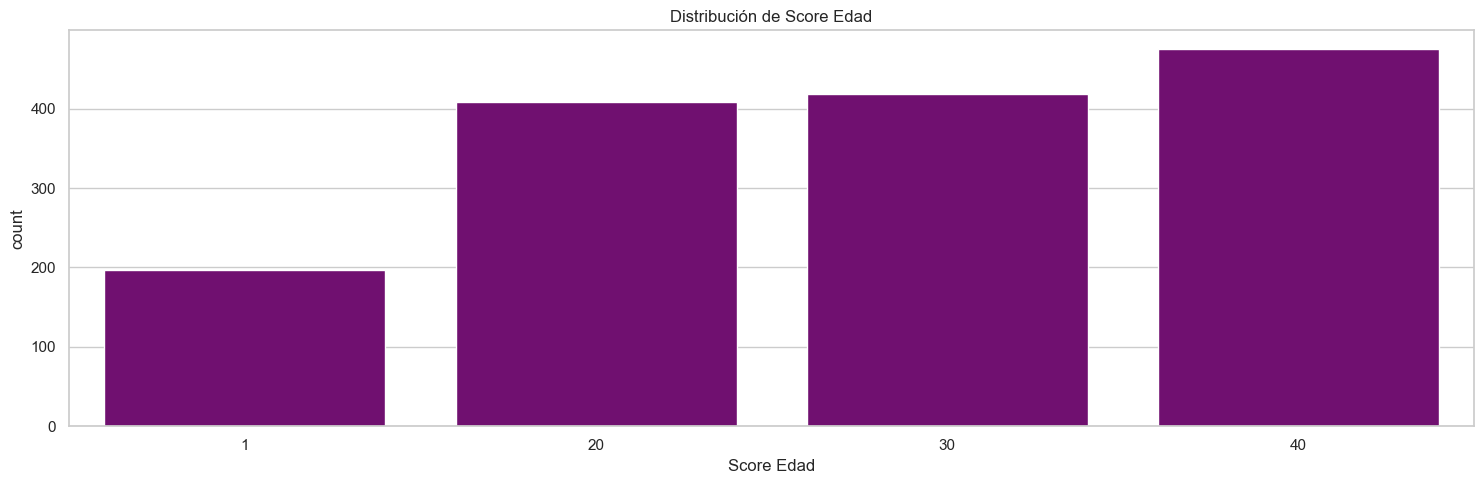


Tabla de Distribución de Frecuencias - Score Edad:
score_edad
40    475
30    419
20    409
1     197
Name: count, dtype: int64


In [7]:
#OMITIR EN score.py
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_edad
sns.countplot(x='score_edad', data=df_edad, color='purple')
plt.title('Distribución de Score Edad')
plt.xlabel('Score Edad')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_edad_counts = df_edad['score_edad'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Edad:")
print(score_edad_counts)


### >>>DISCAPACIDAD.SCORE

In [8]:
def puntaje_discapacidad(grado_dis):
    if grado_dis == 0:
        return 0
    elif grado_dis == 1:
        return 10
    else:  # grado_dis == 2
        return 20

def procesar_discapacidad(df):
    # Copiar el DataFrame para evitar modificar el original
    df_discapacidad = df.copy()

    # Aplicar la función 
    df_discapacidad['score_discapacidad'] = df_discapacidad['grado_dis'].apply(puntaje_discapacidad)

    # Calcular el Min-Max Scaling 
    min_valor = df_discapacidad['score_discapacidad'].min()
    max_valor = df_discapacidad['score_discapacidad'].max()
    rango_deseado = 100
    min_deseado = 0

    df_discapacidad['score_discapacidad_scaled'] = ((df_discapacidad['score_discapacidad'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_discapacidad['score_discapacidad_weighted'] = df_discapacidad['score_discapacidad_scaled'] * discapacidad_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_discapacidad[['dni', 'score_discapacidad', 'score_discapacidad_scaled','score_discapacidad_weighted']].sort_values(by='dni')

# aplicar funcion
df_discapacidad = procesar_discapacidad(df)
df_discapacidad

,dni,score_discapacidad,score_discapacidad_scaled,score_discapacidad_weighted
55,10076758,10,50.0,2.5
1291,10171954,0,0.0,0.0
1193,10196231,0,0.0,0.0
609,10209961,10,50.0,2.5
348,10344303,20,100.0,5.0
...,...,...,...,...
1472,99794603,20,100.0,5.0
144,99913412,10,50.0,2.5
1287,99929175,20,100.0,5.0
24,99949389,0,0.0,0.0


In [9]:
#OMITIR EN score.py
df_discapacidad

,dni,score_discapacidad,score_discapacidad_scaled,score_discapacidad_weighted
55,10076758,10,50.0,2.5
1291,10171954,0,0.0,0.0
1193,10196231,0,0.0,0.0
609,10209961,10,50.0,2.5
348,10344303,20,100.0,5.0
...,...,...,...,...
1472,99794603,20,100.0,5.0
144,99913412,10,50.0,2.5
1287,99929175,20,100.0,5.0
24,99949389,0,0.0,0.0


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


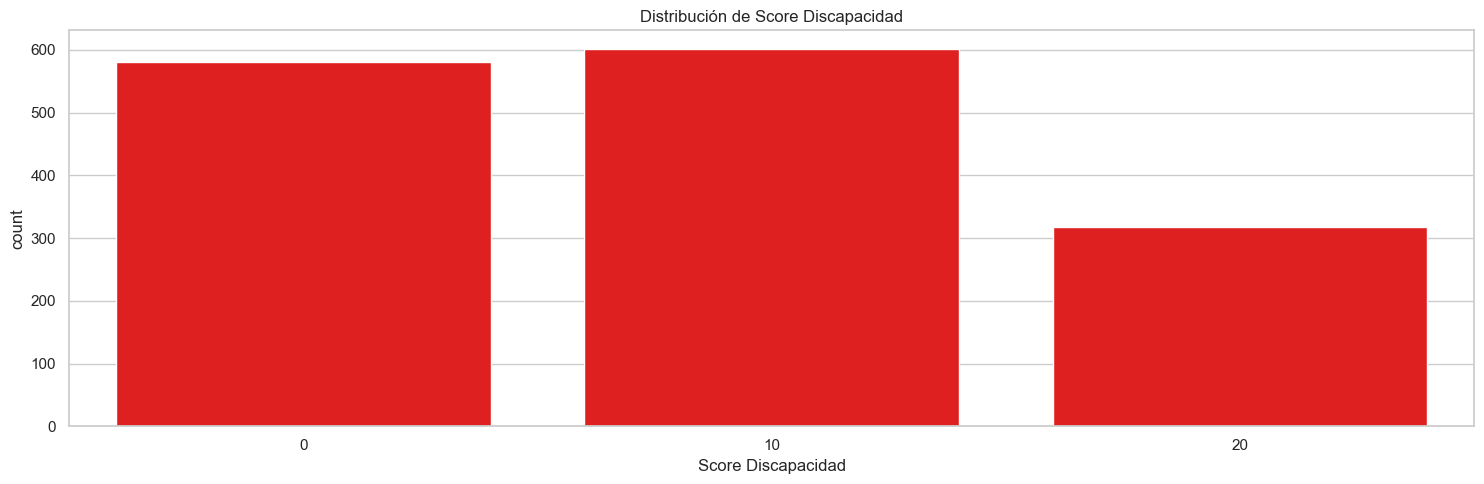


Tabla de Distribución de Frecuencias - Score Discapacidad:
score_discapacidad
10    601
0     581
20    318
Name: count, dtype: int64


In [10]:
#OMITIR EN score.py
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_discapacidad
sns.countplot(x='score_discapacidad', data=df_discapacidad, color='red')
plt.title('Distribución de Score Discapacidad')
plt.xlabel('Score Discapacidad')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_discapacidad_counts = df_discapacidad['score_discapacidad'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Discapacidad:")
print(score_discapacidad_counts)


### >>>SCORE FAMILIA NUMEROSA

In [11]:
def puntaje_familia(tipo_fam_num):
    if tipo_fam_num == 0:
        return 0
    elif tipo_fam_num == 1:
        return 5
    else:  # tipo_fam_num == 2
        return 10

def procesar_familia(df):
    # Copiar el DataFrame para evitar modificar el original
    df_familia = df.copy()

    # Aplicar la función 
    df_familia['score_familia'] = df_familia['tipo_fam_num'].apply(puntaje_familia)

    # Calcular el Min-Max Scaling 
    min_valor = df_familia['score_familia'].min()
    max_valor = df_familia['score_familia'].max()
    rango_deseado = 100
    min_deseado = 0

    df_familia['score_familia_scaled'] = ((df_familia['score_familia'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_familia['score_familia_weighted'] = df_familia['score_familia_scaled'] * familia_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_familia[['dni', 'score_familia', 'score_familia_scaled','score_familia_weighted']].sort_values(by='dni')

# aplicar funcion
df_familia = procesar_familia(df)
df_familia

,dni,score_familia,score_familia_scaled,score_familia_weighted
55,10076758,0,0.0,0.0
1291,10171954,0,0.0,0.0
1193,10196231,10,100.0,5.0
609,10209961,5,50.0,2.5
348,10344303,10,100.0,5.0
...,...,...,...,...
1472,99794603,5,50.0,2.5
144,99913412,0,0.0,0.0
1287,99929175,5,50.0,2.5
24,99949389,0,0.0,0.0


In [12]:
#OMITIR EN score.py
df_familia

,dni,score_familia,score_familia_scaled,score_familia_weighted
55,10076758,0,0.0,0.0
1291,10171954,0,0.0,0.0
1193,10196231,10,100.0,5.0
609,10209961,5,50.0,2.5
348,10344303,10,100.0,5.0
...,...,...,...,...
1472,99794603,5,50.0,2.5
144,99913412,0,0.0,0.0
1287,99929175,5,50.0,2.5
24,99949389,0,0.0,0.0


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


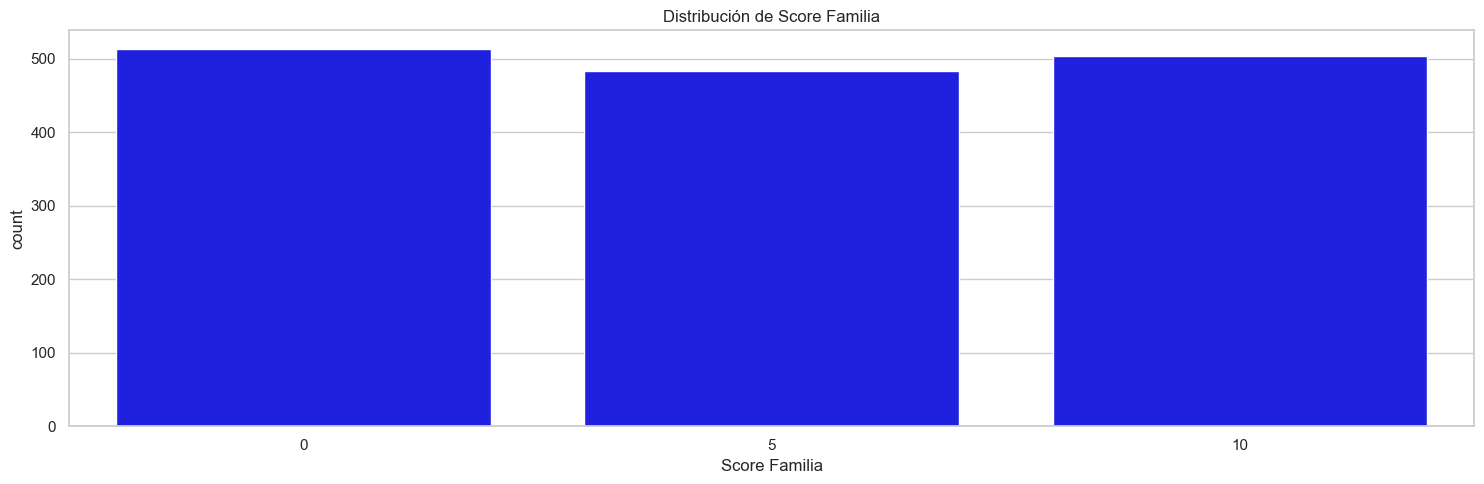


Tabla de Distribución de Frecuencias - Score Familia:
score_familia
0     513
10    504
5     483
Name: count, dtype: int64


In [13]:
#OMITIR EN score.py
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_familia
sns.countplot(x='score_familia', data=df_familia, color='blue')
plt.title('Distribución de Score Familia')
plt.xlabel('Score Familia')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_familia_counts = df_familia['score_familia'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Familia:")
print(score_familia_counts)


### >>>COCHE - ARRENDADOR - OFICIO ESPECIAL

In [14]:
def puntaje_coche_arrendador(coche_arrendador_oficio):
    if coche_arrendador_oficio == True:
        return 0
    else:  #  == False
        return 100

def puntaje_oficio(coche_arrendador_oficio):
    if coche_arrendador_oficio == True:
        return 100
    else:  #  == False
        return 0


def procesar_coche_arrendador_oficio(df):
    # Copiar el DataFrame para evitar modificar el original
    df_coche_arrendador_oficio = df.copy()

    # Aplicar la función 
    df_coche_arrendador_oficio['score_coche'] = df_coche_arrendador_oficio['coche'].apply(puntaje_coche_arrendador)
    df_coche_arrendador_oficio['score_arrendador'] = df_coche_arrendador_oficio['arrendador'].apply(puntaje_coche_arrendador)
    df_coche_arrendador_oficio['score_oficio_especial'] = df_coche_arrendador_oficio['oficio_especial'].apply(puntaje_oficio)


    df_coche_arrendador_oficio['score_coche_weighted'] = df_coche_arrendador_oficio['score_coche'] * coche_wight
    df_coche_arrendador_oficio['score_arrendador_weighted'] = df_coche_arrendador_oficio['score_arrendador'] * arrendador_wight
    df_coche_arrendador_oficio['score_oficio_especial_weighted'] = df_coche_arrendador_oficio['score_oficio_especial'] * oficio_especial_wight
     
    # Devolver el DataFrame con las columnas seleccionadas
    return df_coche_arrendador_oficio[['dni', 'score_coche', 'score_coche_weighted','score_arrendador','score_arrendador_weighted','score_oficio_especial', 'score_oficio_especial_weighted','fecha_de_nacimiento','id_solicitud' ]].sort_values(by='dni')


# aplicar funcion
df_coche_arrendador_oficio = procesar_coche_arrendador_oficio(df)

In [15]:
#OMITIR EN score.py
df_coche_arrendador_oficio

,dni,score_coche,score_coche_weighted,score_arrendador,score_arrendador_weighted,score_oficio_especial,score_oficio_especial_weighted,fecha_de_nacimiento,id_solicitud
55,10076758,0,0.0,0,0.0,0,0.0,1942-12-18,1001
1291,10171954,100,5.0,100,10.0,100,5.0,1943-03-01,791
1193,10196231,100,5.0,0,0.0,0,0.0,1931-12-28,37351
609,10209961,100,5.0,0,0.0,100,5.0,1942-11-08,33532
348,10344303,0,0.0,100,10.0,0,0.0,1945-01-10,1487
...,...,...,...,...,...,...,...,...,...
1472,99794603,0,0.0,0,0.0,100,5.0,1920-02-21,35037
144,99913412,100,5.0,0,0.0,100,5.0,1940-06-02,547
1287,99929175,100,5.0,100,10.0,0,0.0,1929-04-06,38236
24,99949389,0,0.0,100,10.0,0,0.0,1923-08-07,51018


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-package

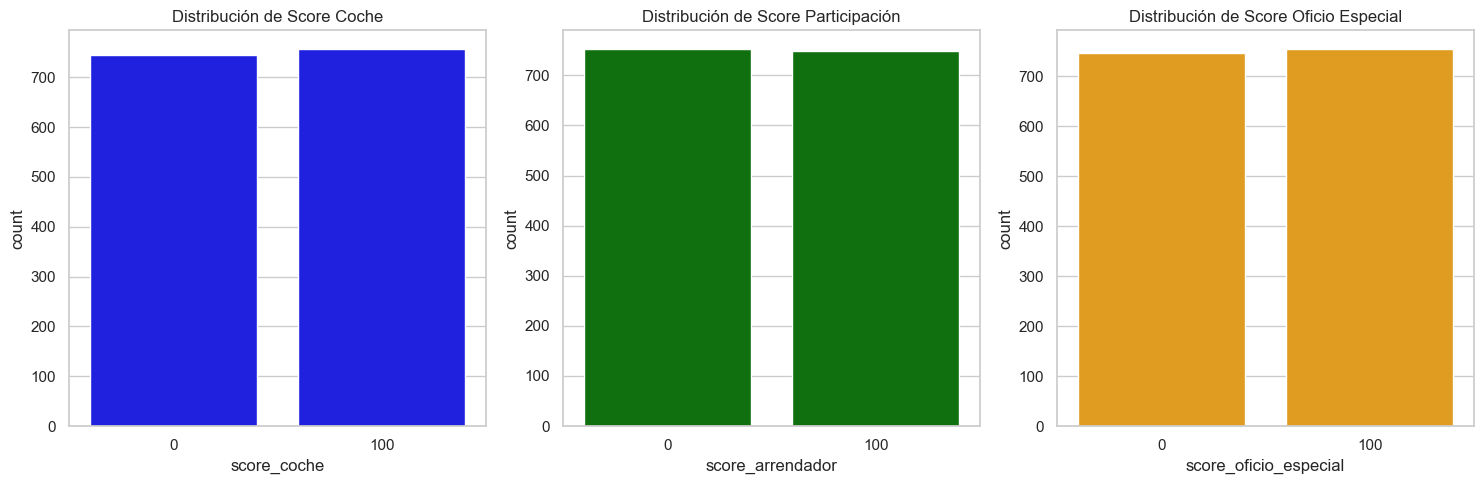


Tabla de Distribución de Frecuencias:

Score Coche:
score_coche
100    756
0      744
Name: count, dtype: int64

Score Participación:
score_arrendador
0      752
100    748
Name: count, dtype: int64

Score Oficio Especial:
score_oficio_especial
100    754
0      746
Name: count, dtype: int64


In [16]:
#OMITIR EN score.py
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráficos
plt.subplot(1, 3, 1)
sns.countplot(x='score_coche', data=df_coche_arrendador_oficio, color='blue')
plt.title('Distribución de Score Coche')

plt.subplot(1, 3, 2)
sns.countplot(x='score_arrendador', data=df_coche_arrendador_oficio, color='green')
plt.title('Distribución de Score Participación')

plt.subplot(1, 3, 3)
sns.countplot(x='score_oficio_especial', data=df_coche_arrendador_oficio, color='orange')
plt.title('Distribución de Score Oficio Especial')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_coche_counts = df_coche_arrendador_oficio['score_coche'].value_counts()
score_arrendador_counts = df_coche_arrendador_oficio['score_arrendador'].value_counts()
score_oficio_especial_counts = df_coche_arrendador_oficio['score_oficio_especial'].value_counts()

print("\nTabla de Distribución de Frecuencias:")
print("\nScore Coche:")
print(score_coche_counts)
print("\nScore Participación:")
print(score_arrendador_counts)
print("\nScore Oficio Especial:")
print(score_oficio_especial_counts)



### >>>PARTICIPACION PREVIA

In [17]:
def participacion_previa(resultado_t_1, suma_viajes_t_1y_t_2, viajes_t_1, viajes_t_2):
    if resultado_t_1 == 2:
        return 175
    elif suma_viajes_t_1y_t_2 == 0:
        return 50
    elif viajes_t_1 == 0 and viajes_t_2 > 0:
        return 40
    elif viajes_t_1 > 0 and viajes_t_2 == 0:
        return 20
    elif suma_viajes_t_1y_t_2 >= 3:
            return 0
    else:
        return 10

def procesar_participacion_previa(df):
    # Copiar el DataFrame para evitar modificar el original
    df_participacion_previa = df.copy()

    # Aplicar la función
    df_participacion_previa['score_participacion_previa'] = df_participacion_previa.apply(
    lambda row: participacion_previa(
        row['resultado_solicitud_t_1'],
        row['suma_viajes_t_1_y_t_2'],
        row['viajes_t_1'],
        row['viajes_t_2']
    ),
    axis=1
    
    
    
)
    # Calcular el Min-Max Scaling 
    min_valor = df_participacion_previa['score_participacion_previa'].min()
    max_valor = df_participacion_previa['score_participacion_previa'].max()
    rango_deseado = 100
    min_deseado = 0

    df_participacion_previa['score_participacion_previa_scaled'] = (
        (df_participacion_previa['score_participacion_previa'] - min_valor) / (max_valor - min_valor)
    ) * rango_deseado + min_deseado

    df_participacion_previa['score_participacion_previa_weighted'] = (
        df_participacion_previa['score_participacion_previa_scaled'] * participacion_previa_weight
    )
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_participacion_previa[[
        'dni', 
        'score_participacion_previa', 
        'score_participacion_previa_scaled',
        'score_participacion_previa_weighted'
    ]].sort_values(by='score_participacion_previa_weighted')

# Aplicar la función
df_participacion_previa = procesar_participacion_previa(df)


In [18]:
#OMITIR EN score.py
df_participacion_previa


,dni,score_participacion_previa,score_participacion_previa_scaled,score_participacion_previa_weighted
272,89133014,0,0.0,0.0
648,95565484,0,0.0,0.0
649,78865239,0,0.0,0.0
1003,66143368,0,0.0,0.0
651,26942307,0,0.0,0.0
...,...,...,...,...
503,50455821,175,100.0,15.0
1115,27740248,175,100.0,15.0
510,63293990,175,100.0,15.0
1133,79491111,175,100.0,15.0


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


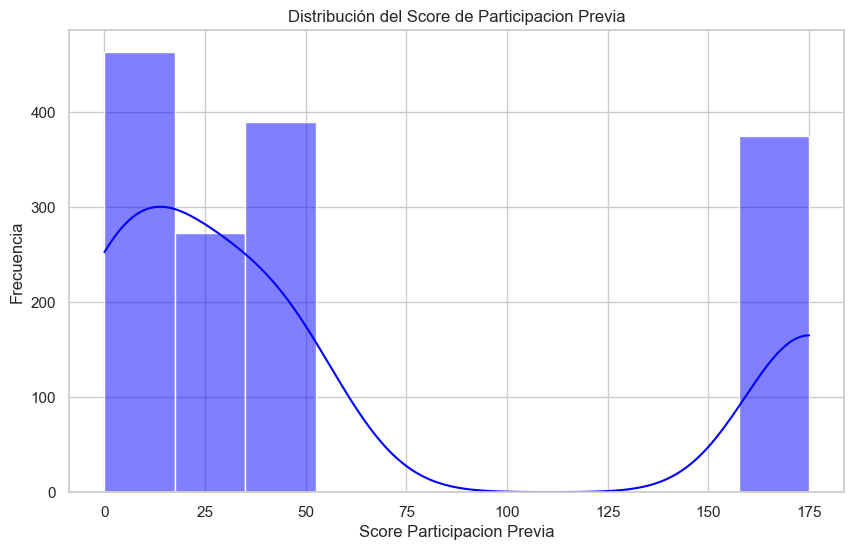

            Rango  Frecuencia
0   (-0.18, 17.5]         463
1    (17.5, 35.0]         273
2    (35.0, 52.5]         389
3    (52.5, 70.0]           0
4    (70.0, 87.5]           0
5   (87.5, 105.0]           0
6  (105.0, 122.5]           0
7  (122.5, 140.0]           0
8  (140.0, 157.5]           0
9  (157.5, 175.0]         375


C:\Users\DELL\AppData\Local\Temp\ipykernel_18076\148513870.py:23: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tabla_frecuencia = pd.value_counts(intervalos).sort_index().reset_index()


In [19]:
#OMITIR EN score.py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Crear el histograma
sns.histplot(df_participacion_previa['score_participacion_previa'], bins=10, kde=True, color='blue')

# Agregar etiquetas y título
plt.xlabel('Score Participacion Previa')
plt.ylabel('Frecuencia')
plt.title('Distribución del Score de Participacion Previa')

# Mostrar el histograma
plt.show()

# Crear intervalos y contar la frecuencia
intervalos = pd.cut(df_participacion_previa['score_participacion_previa'], bins=10, precision=2)
tabla_frecuencia = pd.value_counts(intervalos).sort_index().reset_index()
tabla_frecuencia.columns = ['Rango', 'Frecuencia']

# Mostrar la tabla
print(tabla_frecuencia)


### >>>PATRIMONIO

In [20]:
#OMITIR EN score.py
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dni             1500 non-null   object
 1   id_solicitud    1500 non-null   int64 
 2   id_solicitud    1500 non-null   int64 
 3   anyo_solicitud  1500 non-null   int64 
 4   usuarios_sol    1500 non-null   object
 5   renta_sol       1500 non-null   int64 
 6   patrimonio_sol  1500 non-null   int64 
 7   primera_opcion  1500 non-null   object
 8   fecha_1op       1500 non-null   object
 9   segunda_opcion  1500 non-null   object
 10  fecha_2op       1500 non-null   object
 11  tercera_opcion  1500 non-null   object
 12  fecha_3op       1500 non-null   object
dtypes: int64(5), object(8)
memory usage: 152.5+ KB


In [21]:
def calcular_puntaje_patrimonio(patrimonio_sol):

    # Calcular puntaje basado en las condiciones dadas
    if patrimonio_sol <= 20000:
        return 150
    elif 20000 <= patrimonio_sol <= 40000:
        return 100
    elif 40000 <= patrimonio_sol <= 80000:
        return 55
    elif 80000 <= patrimonio_sol <= 130000:
        return 45
    elif 130000 <= patrimonio_sol <= 170000:
        return 35
    elif 170000 <= patrimonio_sol <= 230000:
        return 25
    elif 230000 <= patrimonio_sol <= 275000:
        return 15
    elif 275000 <= patrimonio_sol <= 325000:
        return 5
    else:
        return 0
    
    
def procesar_patrimonio(df):
    # Copiar el DataFrame para evitar modificar el original
    df_patrimonio = df_2.copy()

    # Calcular puntaje basado en las condiciones dadas
    df_patrimonio['score_patrimonio'] = df_patrimonio['patrimonio_sol'].apply(calcular_puntaje_patrimonio)

    # Calcular el Min-Max Scaling 
    min_valor = df_patrimonio['score_patrimonio'].min()
    max_valor = df_patrimonio['score_patrimonio'].max()
    rango_deseado = 100
    min_deseado = 0

    df_patrimonio['score_patrimonio_scaled'] = ((df_patrimonio['score_patrimonio'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_patrimonio['score_patrimonio_weighted'] = df_patrimonio['score_patrimonio_scaled'] * familia_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_patrimonio[['dni', 'score_patrimonio', 'score_patrimonio_scaled','score_patrimonio_weighted']].sort_values(by='dni')

# Aplicar función
df_patrimonio = procesar_patrimonio(df)

In [22]:
#OMITIR EN score.py
df_patrimonio

,dni,score_patrimonio,score_patrimonio_scaled,score_patrimonio_weighted
55,10076758,0,0.0,0.00
1291,10171954,0,0.0,0.00
1193,10196231,25,25.0,1.25
609,10209961,55,55.0,2.75
348,10344303,25,25.0,1.25
...,...,...,...,...
1472,99794603,25,25.0,1.25
144,99913412,0,0.0,0.00
1287,99929175,0,0.0,0.00
24,99949389,45,45.0,2.25


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


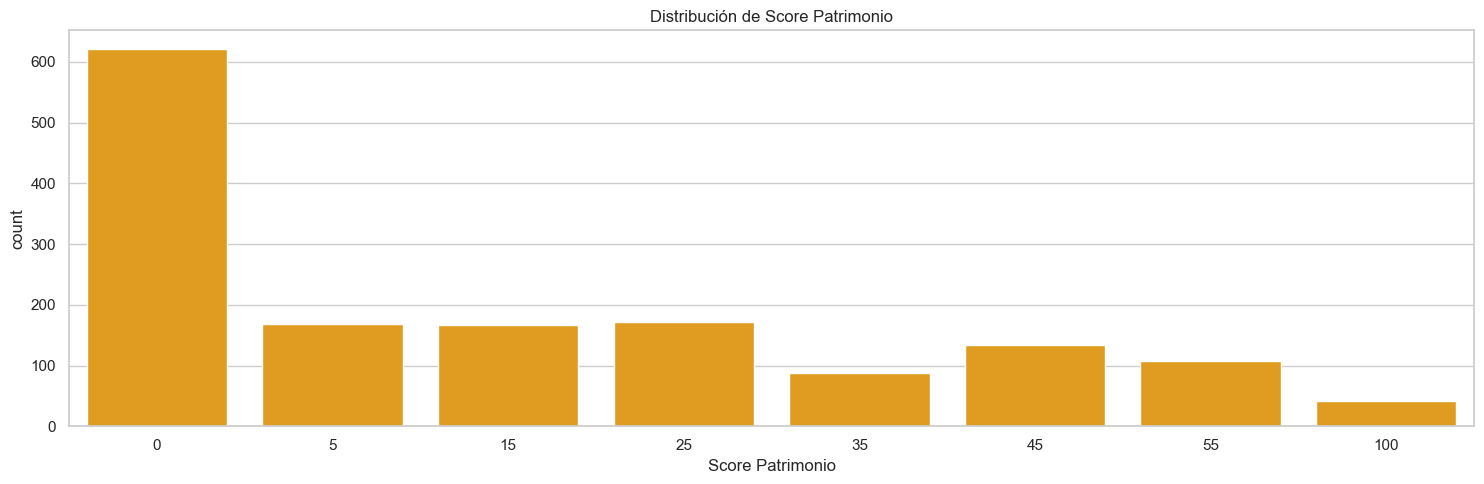


Tabla de Distribución de Frecuencias - Score Patrimonio
score_patrimonio
0      621
25     172
5      169
15     166
45     134
55     108
35      88
100     42
Name: count, dtype: int64


In [23]:
#OMITIR EN score.py
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_patrimonio
sns.countplot(x='score_patrimonio', data=df_patrimonio, color='orange')
plt.title('Distribución de Score Patrimonio')
plt.xlabel('Score Patrimonio')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_patrimonio_counts = df_patrimonio['score_patrimonio'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Patrimonio")
print(score_patrimonio_counts)


### >>>RENTA

In [24]:
def calcular_puntaje_renta(renta_sol, usuarios_sol):
    if usuarios_sol == 2:
        renta_sol /= 1.33

    if renta_sol <= 484.61:
        return 50
    elif 484.61 < renta_sol <= 900:
        return 45
    elif 900 < renta_sol <= 1050:
        return 40
    elif 1050 < renta_sol <= 1200:
        return 35
    elif 1200 < renta_sol <= 1350:
        return 30
    elif 1350 < renta_sol <= 1500:
        return 25
    elif 1500 < renta_sol <= 1650:
        return 20
    elif 1650 < renta_sol <= 1800:
        return 15
    elif 1800 < renta_sol <= 1950:
        return 10
    elif 1950 < renta_sol <= 2100:
        return 5
    else:
        return 0
def procesar_renta(df):
    # Copiar el DataFrame para evitar modificar el original
    df_renta = df_2.copy()

    # Calcular puntaje basado en las condiciones dadas
    df_renta['score_renta'] = df_renta.apply(lambda row: calcular_puntaje_renta(row['renta_sol'], row['usuarios_sol']), axis=1)

    # Calcular el Min-Max Scaling
    min_valor = df_renta['score_renta'].min()
    max_valor = df_renta['score_renta'].max()
    rango_deseado = 100
    min_deseado = 0

    df_renta['score_renta_scaled'] = ((df_renta['score_renta'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_renta['score_renta_weighted'] = df_renta['score_renta_scaled'] * familia_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_renta[['dni', 'score_renta', 'score_renta_scaled', 'score_renta_weighted']].sort_values(by='dni')

# Aplicar función
df_renta = procesar_renta(df)

In [25]:
#OMITIR EN score.py
df_renta


,dni,score_renta,score_renta_scaled,score_renta_weighted
55,10076758,25,50.0,2.5
1291,10171954,35,70.0,3.5
1193,10196231,5,10.0,0.5
609,10209961,15,30.0,1.5
348,10344303,0,0.0,0.0
...,...,...,...,...
1472,99794603,35,70.0,3.5
144,99913412,0,0.0,0.0
1287,99929175,45,90.0,4.5
24,99949389,0,0.0,0.0


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


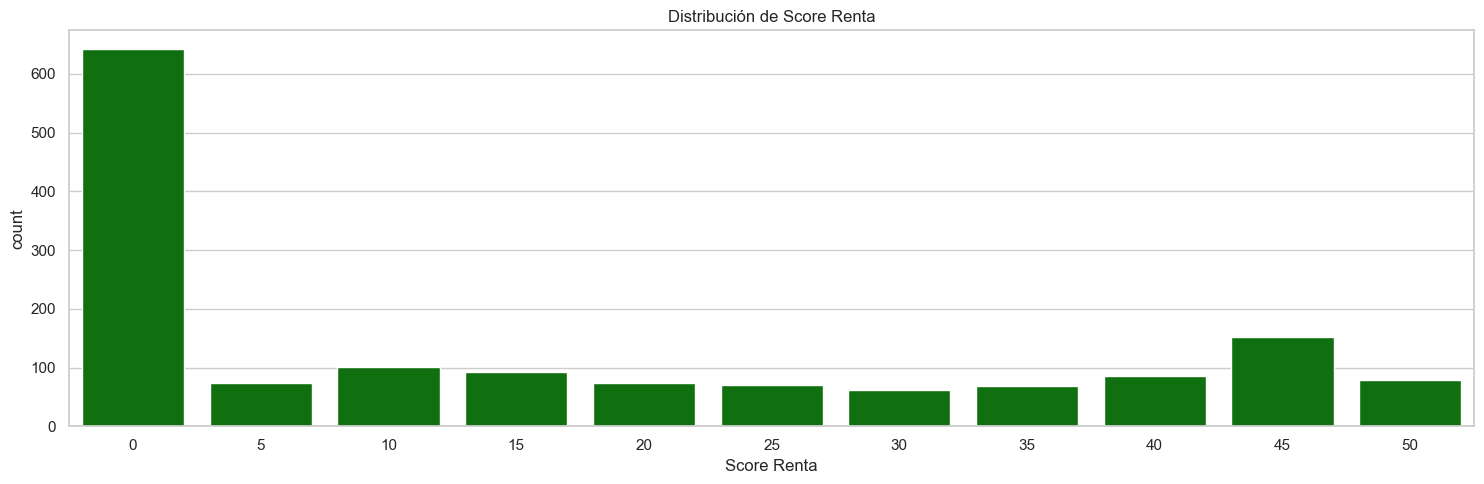


Tabla de Distribución de Frecuencias - Score Renta
score_renta
0     642
45    152
10    101
15     92
40     86
50     79
5      74
20     74
25     70
35     68
30     62
Name: count, dtype: int64


In [26]:
#OMITIR EN score.py
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_renta
sns.countplot(x='score_renta', data=df_renta, color='green')
plt.title('Distribución de Score Renta')
plt.xlabel('Score Renta')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_renta_counts = df_renta['score_renta'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Renta")
print(score_renta_counts)


### >>>MERGE 

In [27]:
#Merge de dataframes
score_merged = pd.merge(df_edad, df_discapacidad, on='dni', how='inner')\
               .merge(df_coche_arrendador_oficio, on='dni', how='inner')\
               .merge(df_participacion_previa, on='dni', how='inner')\
               .merge(df_patrimonio, on='dni', how='inner')\
               .merge(df_renta, on='dni', how='inner')\
               .merge(df_familia, on='dni', how='inner')


# seleccion de columnas que terminan en '_weighted'
columnas_weighted = [col for col in score_merged.columns if col.endswith('_weighted')]

# Crea la nueva columna 'score_total' sumando todas las columnas '_weighted'
score_merged['score_total'] = score_merged[columnas_weighted].sum(axis=1)
score_merged = score_merged.sort_values(by='score_total', ascending=False)



#Seleccion de variables weighted y otras
score_merged_weighted = score_merged.loc[:, [
                                            'id_solicitud' ,
                                            'score_total',
                                            'score_edad_weighted',
                                            'score_discapacidad_weighted',
                                            'score_coche_weighted',
                                            'score_arrendador_weighted',
                                            'score_oficio_especial_weighted',
                                            'score_familia_weighted',
                                            'score_patrimonio_weighted',
                                            'score_renta_weighted',
                                            'score_participacion_previa_weighted']]



score_merged_weighted_rename = {

    'id_solicitud': 'id_solicitud',
    'score_total': 'score',
    'score_edad_weighted': 'edad_score',
    'score_discapacidad_weighted': 'discapacidad_score',
    'score_coche_weighted': 'coche_score',
    'score_arrendador_weighted': 'arrendador_score',
    'score_oficio_especial_weighted': 'oficio_especial_score',
    'score_participacion_previa_weighted': 'part_previa_score',
    'score_patrimonio_weighted': 'patrimonio_score',
    'score_renta_weighted': 'renta_score',
    'score_familia_weighted': 'familia_score'
    
}

# Renombrar todas las columnas
score_merged_weighted = score_merged_weighted.rename(columns=score_merged_weighted_rename)

#Group by para agrupar usuarios en solicitudes. Se usa el promedio entre ambos usuarios
score_merged_weighted_group = score_merged_weighted.groupby('id_solicitud').mean().reset_index()

score_merged_weighted_group['index_'] = score_merged_weighted_group['score'].rank(ascending=False, method='min').astype(int)
score_merged_weighted_group_sorted = score_merged_weighted_group.sort_values(by='index_', ascending=True)
score_merged_weighted_group_sorted['index_'] = score_merged_weighted_group_sorted['index_'].astype(int)



In [28]:
#OMITIR EN score.py
score_merged_weighted_group_sorted

,id_solicitud,score,edad_score,discapacidad_score,coche_score,arrendador_score,oficio_especial_score,familia_score,patrimonio_score,renta_score,part_previa_score,index_
977,43680,67.250000,20.000000,5.0,5.0,10.0,5.0,5.00,2.25,0.0,15.000000,1
311,567,66.250000,20.000000,5.0,5.0,10.0,5.0,0.00,2.75,3.5,15.000000,2
0,2,65.250000,20.000000,5.0,5.0,10.0,5.0,0.00,2.25,3.0,15.000000,3
625,1113,65.250000,20.000000,2.5,5.0,10.0,5.0,2.50,0.75,4.5,15.000000,3
764,1395,65.000000,20.000000,2.5,0.0,10.0,5.0,5.00,5.00,2.5,15.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1090,52025,10.750000,0.000000,0.0,0.0,10.0,0.0,0.00,0.25,0.5,0.000000,1200
501,891,9.464286,0.000000,0.0,0.0,0.0,0.0,2.50,0.75,4.5,1.714286,1201
642,1154,8.621795,4.871795,0.0,2.5,0.0,0.0,1.25,0.00,0.0,0.000000,1202
116,221,8.250000,0.000000,0.0,5.0,0.0,0.0,0.00,2.25,1.0,0.000000,1203


In [29]:
#OMITIR EN score.py
score_merged_weighted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 749 to 1439
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_solicitud           1500 non-null   int64  
 1   score                  1500 non-null   float64
 2   edad_score             1500 non-null   float64
 3   discapacidad_score     1500 non-null   float64
 4   coche_score            1500 non-null   float64
 5   arrendador_score       1500 non-null   float64
 6   oficio_especial_score  1500 non-null   float64
 7   familia_score          1500 non-null   float64
 8   patrimonio_score       1500 non-null   float64
 9   renta_score            1500 non-null   float64
 10  part_previa_score      1500 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 140.6 KB


### >>>EVALUACION DEL MODELO

  Score Range  Número de Usuarios  Porcentaje
2        0-20                 129    8.600000
0       21-40                 873   58.200000
1       41-60                 472   31.466667
3       61-80                  25    1.666667
4      81-100                   0    0.000000


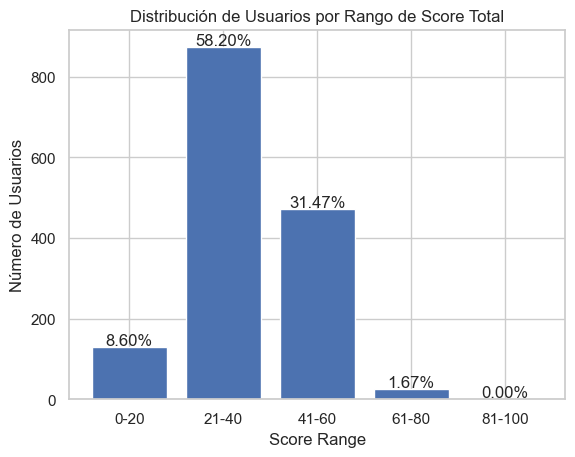

In [30]:
#OMITIR EN score.py
import pandas as pd
import matplotlib.pyplot as plt

# Crear rangos para los puntajes
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

# Agregar una nueva columna 'score_range' al DataFrame
score_merged_weighted['score_range'] = pd.cut(score_merged_weighted['score'], bins=bins, labels=labels)

# Contar usuarios por rango de score
usuarios_por_rango = score_merged_weighted['score_range'].value_counts().reset_index()

# Renombrar las columnas
usuarios_por_rango.columns = ['Score Range', 'Número de Usuarios']

# Calcular el porcentaje de usuarios en cada rango
total_usuarios = len(score_merged_weighted)
usuarios_por_rango['Porcentaje'] = (usuarios_por_rango['Número de Usuarios'] / total_usuarios) * 100

# Ordenar por 'Score Range'
usuarios_por_rango = usuarios_por_rango.sort_values('Score Range')

# Mostrar la tabla
print(usuarios_por_rango)

# Gráfico de barras para visualizar la distribución
plt.bar(usuarios_por_rango['Score Range'], usuarios_por_rango['Número de Usuarios'])
plt.title('Distribución de Usuarios por Rango de Score Total')
plt.xlabel('Score Range')
plt.ylabel('Número de Usuarios')

# Agregar porcentajes en el gráfico
for i, porcentaje in enumerate(usuarios_por_rango['Porcentaje']):
    plt.text(i, usuarios_por_rango['Número de Usuarios'].iloc[i] + 5, f'{porcentaje:.2f}%', ha='center')

plt.show()


### >>>SUBIR TABLA SCORE

In [31]:
# Intentar establecer la conexión
try:
    with psycopg2.connect(connection_string) as connection:
        # Obtener el cursor
        cursor = connection.cursor()

        # Eliminar todos los datos de la tabla scoring
        delete_query = sql.SQL("DELETE FROM scoring")
        cursor.execute(delete_query)

        # Crear una consulta de inserción
        insert_query = sql.SQL("INSERT INTO scoring ({}) VALUES ({})").format(
            sql.SQL(', ').join(map(sql.Identifier, score_merged_weighted_group_sorted.columns)),
            sql.SQL(', ').join(sql.Placeholder() * len(score_merged_weighted_group_sorted.columns))
        )

        # Insertar filas del DataFrame en la tabla de la base de datos
        for _, row in score_merged_weighted_group_sorted.iterrows():
            cursor.execute(insert_query, tuple(row))

        # Confirmar la transacción
        connection.commit()

        print("Datos insertados correctamente en la tabla scoring.")

except psycopg2.Error as e:
    print(f"Error al insertar o borrar datos en la tabla scoring: {e}")


Datos insertados correctamente en la tabla scoring.


### >>> ASIGNACION DE PLAZAS

In [32]:
#Temporizador
time.sleep(5)

# Crear la cadena de conexión
connection_string = f"dbname={dbname} user={user} password={password} host={host} port={port}"

# Intentar establecer la conexión
try:
    with psycopg2.connect(connection_string) as connection:
        # Consulta para concatenar las tablas                        
        query_concatenar_3 = """
            SELECT 
                s.id_solicitud,
                sc.index_,
                sc.score, 
                s.primera_opcion,
                s.fecha_1op,
                s.segunda_opcion, 
                s.fecha_2op,
                s.tercera_opcion,
                s.fecha_3op
            FROM 
                solicitudes s
            JOIN scoring sc ON s.id_solicitud = sc.id_solicitud;
        """

        query_concatenar_5 = """
            SELECT 
                d.id_hotel,
                d.fecha_disponibilidad_hab,
                d.num_hab_disp,
                d.id_plaza,
                ho.localizacion
            FROM disponibilidad d
            JOIN hoteles ho ON d.id_hotel = ho.id_hotel;
        """

        # Crear DataFrames con los resultados de las consultas
        solicitudes = pd.read_sql_query(query_concatenar_3, connection)
        disponibilidad = pd.read_sql_query(query_concatenar_5, connection)

except psycopg2.Error as e:
    print("Error durante la conexión a la base de datos:", e)
finally:
    if connection:
        connection.close()


C:\Users\DELL\AppData\Local\Temp\ipykernel_18076\1200893200.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  solicitudes = pd.read_sql_query(query_concatenar_3, connection)
C:\Users\DELL\AppData\Local\Temp\ipykernel_18076\1200893200.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  disponibilidad = pd.read_sql_query(query_concatenar_5, connection)


In [33]:
#FUNCION DE ASIGNACION
# Función para encontrar una coincidencia entre las preferencias y la disponibilidad
def encontrar_coincidencia(preferencia, fecha_preferencia, disponibilidad, plazas_asignadas):
    filtro = (disponibilidad['fecha_disponibilidad_hab'] == fecha_preferencia) & \
             (disponibilidad['localizacion'] == preferencia)
    coincidencias = disponibilidad[filtro]
    
    # Filtrar solo las plazas que aún no han sido asignadas
    coincidencias = coincidencias[~coincidencias['id_plaza'].isin(plazas_asignadas)]
    
    if not coincidencias.empty:
        id_plaza_asignada = coincidencias.iloc[0]['id_plaza']
        
        # Marcar la plaza como asignada en el DataFrame de disponibilidad
        disponibilidad.loc[disponibilidad['id_plaza'] == id_plaza_asignada, 'asignada'] = True
        
        return id_plaza_asignada
    else:
        return None


disponibilidad['asignada'] = False # Agregar columna 'asignada' en disponibilidad y se inicializa como False
solicitudes['id_plaza'] = None  # Inicializar la columna
solicitudes = solicitudes.sort_values(by='index_') # Ordena df por index 
plazas_asignadas = set()  # Lista para rastrear plazas ya asignadas


#Itera en cada fila aplicando la funcion y respetando el orden del indice
for idx, row in solicitudes.iterrows():
    id_solicitud = row['id_solicitud']
    id_plaza_asignada = encontrar_coincidencia(row['primera_opcion'], row['fecha_1op'], disponibilidad, plazas_asignadas) or \
                        encontrar_coincidencia(row['segunda_opcion'], row['fecha_2op'], disponibilidad, plazas_asignadas) or \
                        encontrar_coincidencia(row['tercera_opcion'], row['fecha_3op'], disponibilidad, plazas_asignadas)

    # Verificar si la plaza ya está asignada o supera la cantidad máxima
    if id_plaza_asignada is not None:
        solicitudes.at[idx, 'id_plaza_asignada'] = id_plaza_asignada
        plazas_asignadas.add(id_plaza_asignada)

#Mensaje de plazas asignadas
plazas_asignadas = disponibilidad['asignada'].sum()
plazas_no_asignadas = disponibilidad.shape[0] - plazas_asignadas

#Preparecion de las id_plaza para subir a tabla scoring
df_id_plaza = solicitudes[['id_solicitud', 'id_plaza_asignada']]
df_id_plaza = df_id_plaza.rename(columns={'id_plaza_asignada': 'id_plaza'})


print(f'Plazas asignadas: {plazas_asignadas}')
print(f'Plazas no asignadas: {plazas_no_asignadas}')



C:\Users\DELL\AppData\Local\Temp\ipykernel_18076\1694733619.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '818886' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  solicitudes.at[idx, 'id_plaza_asignada'] = id_plaza_asignada


Plazas asignadas: 1204
Plazas no asignadas: 796


In [34]:
# Subir asignacion de plaza a tabla score
# Intentar establecer la conexión
try:
    with psycopg2.connect(connection_string) as connection:
        # Obtener el cursor
        cursor = connection.cursor()

        # Actualizar la columna 'id_plaza'
        for _, row in df_id_plaza.iterrows():
            update_query = sql.SQL("UPDATE scoring SET id_plaza = {} WHERE id_solicitud = {}").format(
                sql.Placeholder(), sql.Placeholder()
            )
            cursor.execute(update_query, (row['id_plaza'], row['id_solicitud']))

        # Confirmar la transacción
        connection.commit()

        print("Datos de 'id_plaza' actualizados correctamente en la tabla scoring.")

except psycopg2.Error as e:
    print(f"Error al actualizar datos en la columna 'id_plaza' de la tabla scoring: {e}")


Datos de 'id_plaza' actualizados correctamente en la tabla scoring.


### >>>ACTUALIZAR scoring.py

In [36]:
# OMITIR EN score.py
from nbconvert import PythonExporter
import nbformat

def convert_notebook_to_python(notebook_path, python_path):
    with open(notebook_path, encoding='utf-8') as nb_file:
        notebook = nbformat.read(nb_file, as_version=4)
    
    exporter = PythonExporter()

    # Filtrar las celdas que contienen el comentario especial
    filtered_cells = [
        cell for cell in notebook.cells if '#OMITIR EN score.py' not in cell.source
    ]

    # Crear un nuevo notebook con las celdas filtradas
    filtered_notebook = nbformat.v4.new_notebook(cells=filtered_cells)

    # Convertir el nuevo notebook a código Python
    python_code, _ = exporter.from_notebook_node(filtered_notebook)

    with open(python_path, 'w', encoding='utf-8') as py_file:
        py_file.write(python_code)

# Especifica la ruta del notebook y del archivo Python de salida
notebook_path = 'scoring_jupyter.ipynb'
python_path = 'scoring.py'

# Convierte el notebook a un archivo Python
convert_notebook_to_python(notebook_path, python_path)
